This notebook demonstartes the steps in Stability-based model selection for learning PDEs from data (PDE-STRIDE)
$$
u_t + uu_x = 0.1u_{xx}
$$
In this demo notebook, we show stability selection in combination with three different sparsity promoters LASSO, STRidge and IHT with debiasing 

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
from Iterative_solvers_l0_l1 import *
import scipy.io as sio
import itertools
from operator import itemgetter, attrgetter
import matplotlib.pyplot as plt
from sklearn.linear_model import lars_path, enet_path, lasso_path
from itertools import cycle

import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression

import seaborn as sns
c = sns.color_palette("Blues",20)

Populating the interactive namespace from numpy and matplotlib


/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Import data

In [2]:
X_APR    = loadtxt('Burgers/X_burgers.dat', dtype='double')
T_APR    = loadtxt('Burgers/T_burgers.dat', dtype='double') 

data = sio.loadmat('Burgers/burgers.mat')
u = real(data['usol'])
dx = X_APR[1] - X_APR[0]
dt = T_APR[1] - T_APR[0]
print(" shape of u ", u.shape)
print(" dt is ", dt, " dx is ", dx)

 shape of u  (256, 101)
 dt is  0.1  dx is  0.0625


# Create the design matrix

 shape of un  (256, 101)
 The value of D is changed to 4  4
 length of description  20
i : 1 u
i : 2 u^2
i : 3 u^3
i : 4 u_{x}
i : 5 uu_{x}
i : 6 u^2u_{x}
i : 7 u^3u_{x}
i : 8 u_{xx}
i : 9 uu_{xx}
i : 10 u^2u_{xx}
i : 11 u^3u_{xx}
i : 12 u_{xxx}
i : 13 uu_{xxx}
i : 14 u^2u_{xxx}
i : 15 u^3u_{xxx}
i : 16 u_{xxxx}
i : 17 uu_{xxxx}
i : 18 u^2u_{xxxx}
i : 19 u^3u_{xxxx}
 shape of the truncated description  19
shape 19116 20
shape of no_intercept (19116, 19)


/lustre/projects/jupyterhub/maddukon/Data_driven/Stability_selection_results /PDE-STRIDE/Iterative_solvers_l0_l1.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  X_no_intercept[:,i-1] = X[:,i]


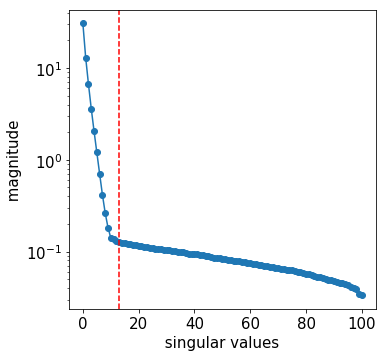

In [5]:


numpy.random.seed(0)
noise_level = 0.03
un = u + noise_level*std(u)*np.random.randn(u.shape[0],u.shape[1])
print(" shape of un ", un.shape)

FUn = un.reshape(u.shape[0],101)
uun,usn,uvn = np.linalg.svd(FUn, full_matrices = False)
dim = 10

# reconstructed
pylab.rcParams['figure.figsize'] = (5.5, 5.5)
plt.rcParams.update({'font.size': 15})
un = (uun[:,:dim].dot(np.diag(usn[:dim]).dot(uvn[:dim,:]))).reshape(u.shape[0],101)
semilogy(usn,'-o')
plt.xlabel(" singular values ")
plt.ylabel(" magnitude ")
count = 0
for i in range(1, 101):
    #print(i, usn[i]/usn[i-1])
    if(usn[i]/usn[i-1] >= 0.99):
        break
    count = count + 1
plt.axvline(x=count, color='r', linestyle='--')

#y, X, description = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')
# In this demo, we don't use SVD based denoising but simply use gaussian blur + polynomial differentiation
y, X, description = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly', space_diff = 'poly',deg_x = 5, deg_t = 5, 
                                      width_x = 10, width_t = 10)
print(" length of description ", len(description))
description_trunc, X_no_intercept = remove_intercept(X, description) # This step removes the constant column in the design
u_t = y

# Compute regularization path for a random sub-sample

In [99]:
np.random.seed(3)
reduced_size = 100
ordered = np.arange(0, len(u_t))
np.random.shuffle(ordered)

X_reduced = np.zeros((reduced_size, len(description_trunc))) # random sub-sample from the design matrix
y_reduced = np.zeros((reduced_size,1))                       # random sub-sample from the measurement vector
X_stand   = np.zeros((reduced_size, len(description_trunc))) # standardized sub-design matrix
y_stand   = np.zeros((reduced_size,1))                       # standardized sub-measurement vector

for i in range(0, reduced_size):
    X_reduced[i,:] = X_no_intercept[int(ordered[i]),:]
    y_reduced[i,:] = u_t[int(ordered[i])]

X_stand = preprocessing.scale(X_reduced)
y_stand = preprocessing.scale(y_reduced, with_std=False)
y_stand = y_stand.reshape(reduced_size,1)

mul_vector = np.matmul(X_stand.transpose(), y_stand)     
lambda_max = (1.0/reduced_size)*np.linalg.norm(mul_vector, np.inf)  # lambda_{max} in paper 
M             = 20 # M in the paper
factor        = np.exp(np.log(10.)/M)
lambda_regl   = np.zeros((M,1))
coeff_alpha   = np.zeros((len(description_trunc),M)) # stores the output

alphas_regl = np.zeros((M,1))
for alpha in range(0, M):
    alphas_regl[alpha] = lambda_max/factor**alpha
    
normalized_alphas_sample = np.zeros((M,))
normalized_alphas_sample = alphas_regl/alphas_regl[0]
neg_log_stable_lambda = -np.log10(normalized_alphas_sample)

print(" lambda max is ", alphas_regl[0], " lambda min is ", alphas_regl[M-1])
print(" lambda max is ", normalized_alphas_sample[0], " lambda min is ", normalized_alphas_sample[M-1])

p = X_stand.shape[1]
coefs_lasso   = np.zeros((p, M))
coefs_ihtd    = np.zeros((p, M))
coefs_STR     = np.zeros((p, M))

print(" norm is ", np.linalg.norm(X_stand.T.dot(X_stand),2))

for alpha in range(0, M):
    clf_l = linear_model.Lasso(alphas_regl[alpha], fit_intercept=False, max_iter=10000, tol=1e-8) #L1
    clf_l.fit(X_stand,y_stand)
    coefs_lasso[:,alpha] = clf_l.coef_
        
    clf_ihtd = Iterative_hard_thresholding_debias(X_stand, y_stand, alphas_regl[alpha], max_iter=10000, sub_iter=25, tol=1e-8, htp_flag = 1, print_flag=True)
    coefs_ihtd[:, alpha] = clf_ihtd[:]
    
    clf_STR = STRidge(X_stand, y_stand, alphas_regl[alpha], lam = 10**-5, max_iter=10000)
    coefs_STR[:,alpha] = clf_STR[:]

    print(" done with alpha ", alpha)

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/lustre/projects/jupyterhub/maddukon/Data_driven/Stability_selection_results /PDE-STRIDE/Iterative_solvers_l0_l1.py:375: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: coeff[0,biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0].reshape(len(biginds),)


 lambda max is  [0.06020405]  lambda min is  [0.00675501]
 lambda max is  [1.]  lambda min is  [0.11220185]
 norm is  954.0552508734525
 done with alpha  0
 done with alpha  1
 converged at iteration  3  frac_iter  1.0  flag  1
 done with alpha  2
 done with alpha  3
 done with alpha  4
 done with alpha  5
 done with alpha  6
 done with alpha  7
 converged at iteration  9  frac_iter  0.8  flag  1
 done with alpha  8
 converged at iteration  97  frac_iter  1.0  flag  1
 done with alpha  9
 converged at iteration  95  frac_iter  1.0  flag  1
 done with alpha  10
 converged at iteration  24  frac_iter  1.0  flag  1
 done with alpha  11
 converged at iteration  28  frac_iter  0.9655172413793104  flag  1
 done with alpha  12
 converged at iteration  30  frac_iter  0.967741935483871  flag  1
 done with alpha  13
 converged at iteration  33  frac_iter  0.9705882352941176  flag  1
 done with alpha  14
 converged at iteration  40  frac_iter  0.975609756097561  flag  1
 done with alpha  15
 conv

Text(0,0.5,'$\\beta$')

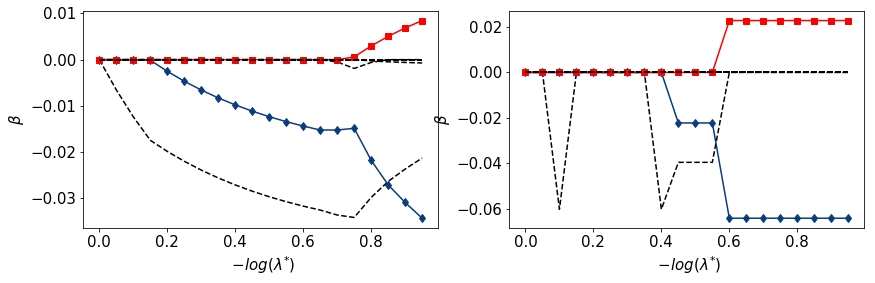

In [100]:
pylab.rcParams['figure.figsize'] = (14, 4.)
plt.rcParams.update({'font.size': 15})
covar_1 = 4 # advection term
covar_2 = 7 # diffusion term

plt.subplot(1,2,1)
for i in range(0, p):
    if(i == covar_1):
        plt.plot(neg_log_stable_lambda, coefs_lasso[i,:],'-d',color=c[19])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, coefs_lasso[i,:],'-s',color='red')
    else:
        plt.plot(neg_log_stable_lambda, coefs_lasso[i,:],'--',color='black')
plt.xlabel(" $ -log(\lambda^{*}) $")
plt.ylabel(r'$\beta$')
        
plt.subplot(1,2,2)
for i in range(0, p):
    if(i == covar_1):
        plt.plot(neg_log_stable_lambda, coefs_ihtd[i,:],'-d',color=c[19])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, coefs_ihtd[i,:],'-s',color='red')
    else:
        plt.plot(neg_log_stable_lambda, coefs_ihtd[i,:],'--',color='black')
plt.xlabel(" $ -log(\lambda^{*}) $")
plt.ylabel(r'$\beta$')

In [34]:
coefs_ihtd[i,:5]

array([0., 0., 0., 0., 0.])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

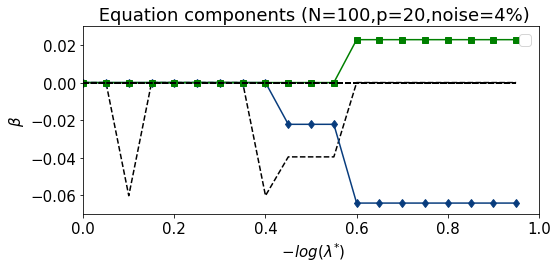

In [102]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(0, 1.0), ylim=(-0.06, 0.03))
line, = ax.plot([], [], '-o', color='red',lw=3)
pylab.rcParams['figure.figsize'] = (8, 4)
plt.rcParams.update({'font.size': 15})
plt.tight_layout()
index = np.arange(0, 256, 4)
plt.title(" 1D Burgers solution ")

def init():
    x = neg_log_stable_lambda
    #line.set_data(x[:], y)
    plt.plot()
    plt.tight_layout()
    return line,
def animate(i):
    index = i
    plt.clf()
    #x = np.linspace(-8, 8, len(index))
    #y = un[index,i]
    time = i*0.1
    for i in range(0, p):
        if(i == covar_1):
            plt.plot(neg_log_stable_lambda[:index], coefs_ihtd[i,:index],'-d',color=c[19])
        elif(i == covar_2):
            plt.plot(neg_log_stable_lambda[:index], coefs_ihtd[i,:index],'-s',color='green')
        else:
            plt.plot(neg_log_stable_lambda[:index], coefs_ihtd[i,:index],'--',color='black')
    
    #plt.plot(x,y,'-',color='black',label='time=%.2f'%time+'s')
    plt.legend(loc='best',fontsize=15)
    plt.xlabel(" $ -log(\lambda^{*}) $")
    #text(0.01, 0.011, 'surya', fontsize=12)
    plt.ylabel(r'$\beta$')
    #plt.plot(x,y,'o',color='red')
    plt.ylim(-0.07, 0.03)
    plt.xlim(0,1.0)
    plt.title(" Equation components (N=100,p=20,noise=4%)")
    plt.tight_layout()
    #line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,frames=40, interval=1, blit=True)
anim.save('IHT2_N100.gif', writer='imagemagick')

 shape of ceofs_lasso  (19, 20)
0.872042105263158


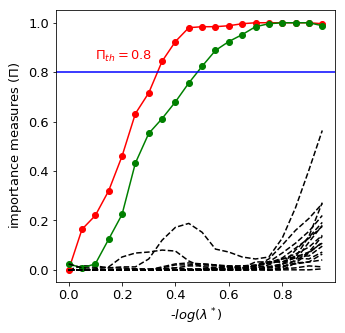

In [167]:
coefs_ihtd = np.loadtxt('../Actual_stability_plots/Iterative_solvers_comparison/paper_plots/Burgers/HTP_Burgers_n0.04_N250_p19_dim15_B250.txt', dtype='double')

d, alphas_size = coefs_ihtd.shape
print(" shape of ceofs_lasso ", coefs_ihtd.shape)

derv = ['u_{x}', 'u_{xx}','u_{xxx}','u_{xxxx}']
nonlinear = ['u','u^2','u^3']
pylab.rcParams['figure.figsize'] = (11, 5)

covar_1 = 4 #PP + 1
covar_2 = 7 #2*PP + 1

plt.subplot(1,2,1)
#plt.subplot(fig_count,1,count)
for i in range(0, d):
    if(i == covar_1):
        plt.plot(neg_log_stable_lambda, coefs_ihtd[i,:],'-o',color='red')
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, coefs_ihtd[i,:],'-o',color='green')
    else:
        plt.plot(neg_log_stable_lambda, coefs_ihtd[i,:],'--',color='black')
        
#plt.legend(loc='best', prop={'size':13})
#plt.legend(loc='best')
plt.rcParams.update({'font.size': 13})
plt.text(0.1, 0.85,'$\Pi_{th}=0.8$', color='red')
plt.axhline(y=0.8, color='b', linestyle='-')
plt.xlabel(" -$log(\lambda^*)$ ")
plt.ylabel(" importance measures $(\Pi)$ ")
#plt.ylabel(" coefficients ")
q = np.sum(coefs_ihtd[:,18])
print(0.5 + q**2/(2.0*19))

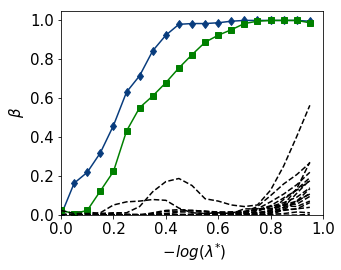

In [151]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(0, 1.0), ylim=(0, 1.05))
line, = ax.plot([], [], '-o', color='red',lw=3)
pylab.rcParams['figure.figsize'] = (5, 4)
plt.rcParams.update({'font.size': 15})
plt.tight_layout()
index = np.arange(0, 256, 4)
plt.title(" 1D Burgers solution ")

def init():
    x = neg_log_stable_lambda
    #line.set_data(x[:], y)
    plt.plot()
    plt.tight_layout()
    return line,
def animate(i):
    index = i
    plt.clf()
    #x = np.linspace(-8, 8, len(index))
    #y = un[index,i]
    time = i*0.1
    for i in range(0, p):
        if(i == covar_1):
            plt.plot(neg_log_stable_lambda[:index], coefs_ihtd[i,:index],'-d',color=c[19])
        elif(i == covar_2):
            plt.plot(neg_log_stable_lambda[:index], coefs_ihtd[i,:index],'-s',color='green')
        else:
            plt.plot(neg_log_stable_lambda[:index], coefs_ihtd[i,:index],'--',color='black')
    
    #plt.plot(x,y,'-',color='black',label='time=%.2f'%time+'s')
    #plt.legend(loc='best',fontsize=15)
    plt.xlabel(" $ -log(\lambda^{*}) $")
    #text(0.01, 0.011, 'surya', fontsize=12)
    plt.ylabel(r'$\beta$')
    #plt.plot(x,y,'o',color='red')
    plt.ylim(0,1.05)
    plt.xlim(0,1.0)
    #plt.title(" Equation components (N=100,p=20,noise=4%)")
    plt.tight_layout()
    #line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,frames=40, interval=1, blit=True)
anim.save('stability_selection_Burgers_np4.gif', writer='imagemagick')

# Stability plots 

In [ ]:
np.random.seed(10)

B   = 100   # convention as in paper
N   = 1500   # N in the paper
ordered_reduced = np.arange(0, len(u_t))
np.random.shuffle(ordered_reduced)
X_reduced = np.zeros((N, p))
y_reduced = np.zeros((N, 1))
for i in range(0, N):
    X_reduced[i,:] = X_no_intercept[int(ordered_reduced[i]),:]
    y_reduced[i]   = u_t[int(ordered_reduced[i])]  # changed 
        
n, d = X_reduced.shape    
alphas_sample = np.zeros((B, M))
subsample_info_lasso = np.zeros((B, p, M))
subsample_info_RLasso = np.zeros((B, p, M))
subsample_info_STR    = np.zeros((B, p, M))
subsample_info_iht_d  = np.zeros((B, p, M))
    
sub_size = int(n/2)   # the subsize is not complimentary though
X_sub = np.zeros((B, sub_size, p))
y_sub = np.zeros((B, sub_size))
ordered_subsample = np.arange(0, n)  # form an array from 0 to n
for sample in range(0, B):
    np.random.shuffle(ordered_subsample)
    for j in range(0, sub_size):
        X_sub[sample, j, :] = X_reduced[int(ordered_subsample[j]),:]
        y_sub[sample, j]    = y_reduced[int(ordered_subsample[j]),:]  
    
Xs_sub = np.zeros((B, sub_size, p))
ys_sub = np.zeros((B, sub_size)) 
# standardizing X_sub
scaler = StandardScaler()
for sample in range(0, B):
        #temp_x, variance =  standardization(X_sub[sample], 1, False)
    temp_x = preprocessing.scale(X_sub[sample])
    Xs_sub[sample] = temp_x
    ys_sub[sample] = preprocessing.scale(y_sub[sample],with_std=False)
    scaler.fit(X_sub[sample])
        
Xs_sub = Xs_sub.reshape((B, sub_size, p)) 
ys_sub = ys_sub.reshape((B, sub_size))

factor      = np.exp(np.log(10)/M)
weakness    = 0.2
for sample in range(0, B):
    alphas_lasso, coefs_lasso, _ = lasso_path(Xs_sub[sample], ys_sub[sample], eps=0.1,
                                                      n_alphas=M, fit_intercept=False)
    coefs_lasso = coefs_lasso.reshape(p, M)
    alphas_sample[sample, :] = alphas_lasso
    for alpha in range(0, M):
        subsample_info_lasso[sample,:,alpha] = coefs_lasso[:,alpha]
 
    for alpha in range(0, M):   
        X = Xs_sub[sample]
        y = ys_sub[sample]
        y = y.reshape(sub_size,1)
        
        diagonal = np.zeros((p, p))
        for diag in range(0, p):
            alpha_random = np.random.uniform(1.0, 1.0/weakness,1)
            diagonal[diag, diag] = alpha_random
        
        theta = np.matmul(Xs_sub[sample], np.linalg.inv(diagonal))
        clf_lasso = linear_model.Lasso(alphas_sample[sample,alpha], fit_intercept=False, max_iter=10000, tol=1e-8, warm_start=True)
        clf_lasso.fit(theta,y)
        subsample_info_RLasso[sample,:, alpha] = clf_lasso.coef_
        
        coefs_iht_d = Iterative_hard_thresholding_debias(X, y, alphas_sample[sample,alpha], max_iter=10000, sub_iter=25, tol=1e-8, htp_flag = 1)
        subsample_info_iht_d[sample,:,alpha] = coefs_iht_d[:]
        coefs_STR   = STRidge(X, y, alphas_sample[sample,alpha], lam = 10**-5, max_iter=10000)
        subsample_info_STR[sample,:,alpha] = coefs_STR[:]
            
    if(sample%5 == 0):
        print(" done with sample ", sample, " size ", reduced_size)

In [ ]:
covar_1 =  4#PP + 1
covar_2 =  7#2*PP + 1

normalized_alphas_sample = np.zeros((B, M))
for sample in range(0, B):
    normalized_alphas_sample[sample,:] = alphas_sample[sample,:]/alphas_sample[sample,0]
neg_log_stable_lambda = -np.log10(normalized_alphas_sample[0,:])

importance_plot = np.zeros((p, M))
for alpha in range(0, M):
    for i in range(0, p):
        for sample in range(0, B):
            if(subsample_info_RLasso[sample, i, alpha] != 0):
                importance_plot[i,alpha] = importance_plot[i,alpha] + 1

        importance_plot[i,alpha] = importance_plot[i,alpha]/B

plt.subplot(1,3,1)
for i in range(0, p):
    if(i == covar_1 ):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-d',color=c[19],label='$cov = %s$' %description_trunc[i])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-s', color=c[11],label='$cov = %s$' %description_trunc[i])
    else:
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '--', color='black')


plt.rcParams.update({'font.size': 12})
plt.title(" lasso ")
plt.xlabel(" $ -log(\lambda^{*}) $ ")
plt.ylabel(" $ \Pi $")
plt.ylim(0, 1.05)  
plt.legend(loc='best', prop={'size':13})
plt.text(0.3, 0.85,'$\pi_{th}=0.8$',color='red')
plt.axhline(y=0.8, color='r', linestyle='-')
pylab.rcParams['figure.figsize'] = (15, 7.5)

importance_plot = np.zeros((p, M))
for alpha in range(0, M):
    for i in range(0, p):
        for sample in range(0, B):
            if(subsample_info_iht_d[sample, i, alpha] != 0):
                importance_plot[i,alpha] = importance_plot[i,alpha] + 1

        importance_plot[i,alpha] = importance_plot[i,alpha]/B

plt.subplot(1,3,2)
for i in range(0, p):
    if(i == covar_1 ):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-d',color=c[19],label='$cov = %s$' %description_trunc[i])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-s', color=c[11],label='$cov = %s$' %description_trunc[i])
    else:
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '--', color='black')
        
plt.rcParams.update({'font.size': 12})
plt.title(" Iterative hardthresholding with debias (IHT-d) ")
plt.xlabel(" $ -log(\lambda^{*}) $ ")
plt.ylabel(" $ \Pi $")
plt.ylim(0, 1.05)  
plt.legend(loc='best', prop={'size':13})
plt.text(0.8, 0.85,'$\pi_{th}=0.8$',color='red')
plt.axhline(y=0.8, color='r', linestyle='-')
pylab.rcParams['figure.figsize'] = (15, 7.5)

importance_plot = np.zeros((p, M))
for alpha in range(0, M):
    for i in range(0, p):
        for sample in range(0, B):
            if(subsample_info_STR[sample, i, alpha] != 0):
                importance_plot[i,alpha] = importance_plot[i,alpha] + 1

        importance_plot[i,alpha] = importance_plot[i,alpha]/B

plt.subplot(1,3,3)
for i in range(0, p):
    if(i == covar_1 ):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-d',color=c[19],label='$%s$' %description_trunc[i])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-s', color=c[11],label='$%s$' %description_trunc[i])
    else:
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '--', color='black')
        

plt.rcParams.update({'font.size': 12})
plt.title(" STRidge ")
plt.xlabel(" $ -log(\lambda^{*}) $ ")
plt.ylabel(" $ \pi $")
plt.ylim(0, 1.05)  
plt.text(0.2, 0.85,'$ \sigma =0.8$', color='red')
plt.legend(loc='best', prop={'size':13})
plt.axhline(y=0.8, color='r', linestyle='-')
pylab.rcParams['figure.figsize'] = (16, 5)